<center>

# <span style="color:blue"> Relazione 7 </span>

</center>

**NB:** in questa esercitazione è utilizzata la libreria random.h, necessaria per generare uniformemente numeri casuali. Tale libreria si trova nella cartella RANDOM_GEN: per compilare è prima necessario utilizzare il comando 'source setup.sh'. Il file setup.sh si trova nella cartella LSN_Delivery

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math

from scipy.optimize import curve_fit

L'obiettivo dell'esercitazione 7 è simulare via metodi MC NVT (ossia nell'ensamble canonico) il comportamento di un sistema di atomi di Argon ($\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu) nelle seguenti condizioni:
1. fase solida: $\rho^\star = 1.1$, $T^\star = 0.8$ (raggio di cut-off: $r_c = 2.2$)

2. fase liquida: $\rho^\star = 0.8$, $T^\star = 1.1$ (raggio di cut-off: $r_c = 2.5$)

3. fase gassosa: $\rho^\star = 0.05$, $T^\star = 1.2$ (raggio di cut-off: $r_c = 5.0$)

Verranno inoltre comparate le funzioni di distribuzione radiale MC con quelle ottenute con le simulazioni Molecular Dynamics NVE in condizioni termodinamiche confrontabili.

### Ensamble canonico

L'ensamble canonico è un insieme statistico che descrive un sistema chiuso in equilibrio termico con un "bagno di calore": spesso viene indicato come NVT, in quanto numero di particelle, volume del contenitore e temperatura sono costanti. La densità di probabilità tipica dell'ensamble canonico è:
$$
\rho\left(q,\,p\right)\,=\,\frac{\exp{\left(-H\left(p,\,q\right)/k_BT\right)}}{Q_N\left(V,\,T\right)}
$$
dove $Q_N\left(V,\,T\right)$ è il volume occupato dall'ensamble canonico nello spazio delle fasi. Tale funzione è detta **funzione di partizione** ed è definita come:
$$
Q\left(V,\,T\right)\,=\,\int \frac{d^{3N}q\,d^{3N}p}{h^{3N}N!} \exp{\left(-H\left(p,\,q\right)/k_BT\right)}
$$
<br>

Il metodo di evoluzione MC-NVT ad ogni mossa prova ad evolvere le posizioni di tutte le particelle costituenti il sistema. Il singolo tentativo di mossa viene performato su una particella estratta uniformemente: si propone come mossa un update delle coordinate $ \left(x,\,y,\,z\right) $ campionando uniformemente un intervallo di grandezza $\delta$ contrato sulle posizioni attuali della particella. Si valuta l'energia nella nuova configurazione e si accetta la mossa con probabilità:
$$
p_{move}\,=\,\min\left[1, \exp{\left(-\beta \Delta E\right)}\right]
$$
Il parametro delta deve essere fissato in modo tale da avere un acceptance rate di circa il 50%

## <span style="color:blue"> Tail correction </span>

Il calcolo di osservabili come energia potenziale e pressione era influenzato dal fatto che venisse utilizzato cut-off sferico: non tutte le particelle erano quindi prese in considerazione. Lavorando con la $g\left(r\right)$ è possibile effettuare delle tail correction che permettano di ottenere dei risultati numericamente validi.

<center>

Energia potenziale

</center>

Il valore di aspettazione dell'energia potenziale è dato dal seguente integrale:
$$
\langle V \rangle\,=\,\int d\vec{r_1}\dots d\vec{r_N} \frac{exp{\left(-\beta V\left(\vec{r_1},\dots,\vec{r_N}\right)\right)}}{Z_N} V\left(\vec{r_1},\dots,\vec{r_N}\right)\,=\,\dots\,=\,2\pi\rho N\int_0^{+\infty}dr\,r^2v(r)g(r)
$$
Il potential cut-off blocca la stima del valore di aspettazione ad $r\,=\,r_c$. Le correzioni sono solitamente ottenute assumendo $g\left(r\right)\,\simeq\,1$ per $r\gt r_c$, che nel caso del potenziale si traduce in:
$$
\langle V \rangle _{tail}\,=\,2\pi\rho N\int_{r_c}^{+\infty}dr\,r^2v(r)g(r)\,=\,\dots\,=\,8\pi\epsilon N\rho _{LJ}\left(\frac{1}{9r_c^9}\,-\,\frac{1}{3r_c^3}\right)
$$

<center>

Pressione

</center>

La tail correction per la pressione è data da:

$$
\frac{\langle w_{LJ}\rangle_{tail}}{3N\epsilon}\,=\,32\pi\rho _{LJ}\left(\frac{1}{9r_c^9}\,-\,\frac{1}{6r_c^3}\right)
$$

Queste correzioni sono state aggiunte nel codice "MD_MC.cpp", in particolare nella parte in cui viene calcolato il viriale: in "Avarages()" vengono poi aggiunte nelle stime di energia potenziale e pressione moltiplicando per gli opportuni fattori.

## <span style="color:blue"> Equilibrazione </span>

In [2]:
#Carico dati da file
gassoso = np.loadtxt("Equilibrazioni/Gassoso.dat", unpack=True)
liquido = np.loadtxt("Equilibrazioni/Liquido.dat", unpack=True)
solido = np.loadtxt("Equilibrazioni/Solido.dat", unpack=True)

T = np.array([1.2, 1.1, 0.8])

Una volta inizializzato il sistema si deve attendere fino al raggiungimento dell'equilibrio. Nel caso del Molecular Dynamics l'osservabile da controllare è la temperatura del sistema, mentre per MC possiamo lavorare con l'energia potenziale. Tutte le simulazioni all'equilibrio effettuate per questa esercitazione sono da 50 blocchi, ciascuno da 10000 punti (si vedrà in seguito che questa dimensione è lecita): data la differente lunghezza delle simulazioni rispetto a quelle dell'esercitazione 4 rifaccio anche le equilibrazioni del codice MD.

#### Fase gassosa

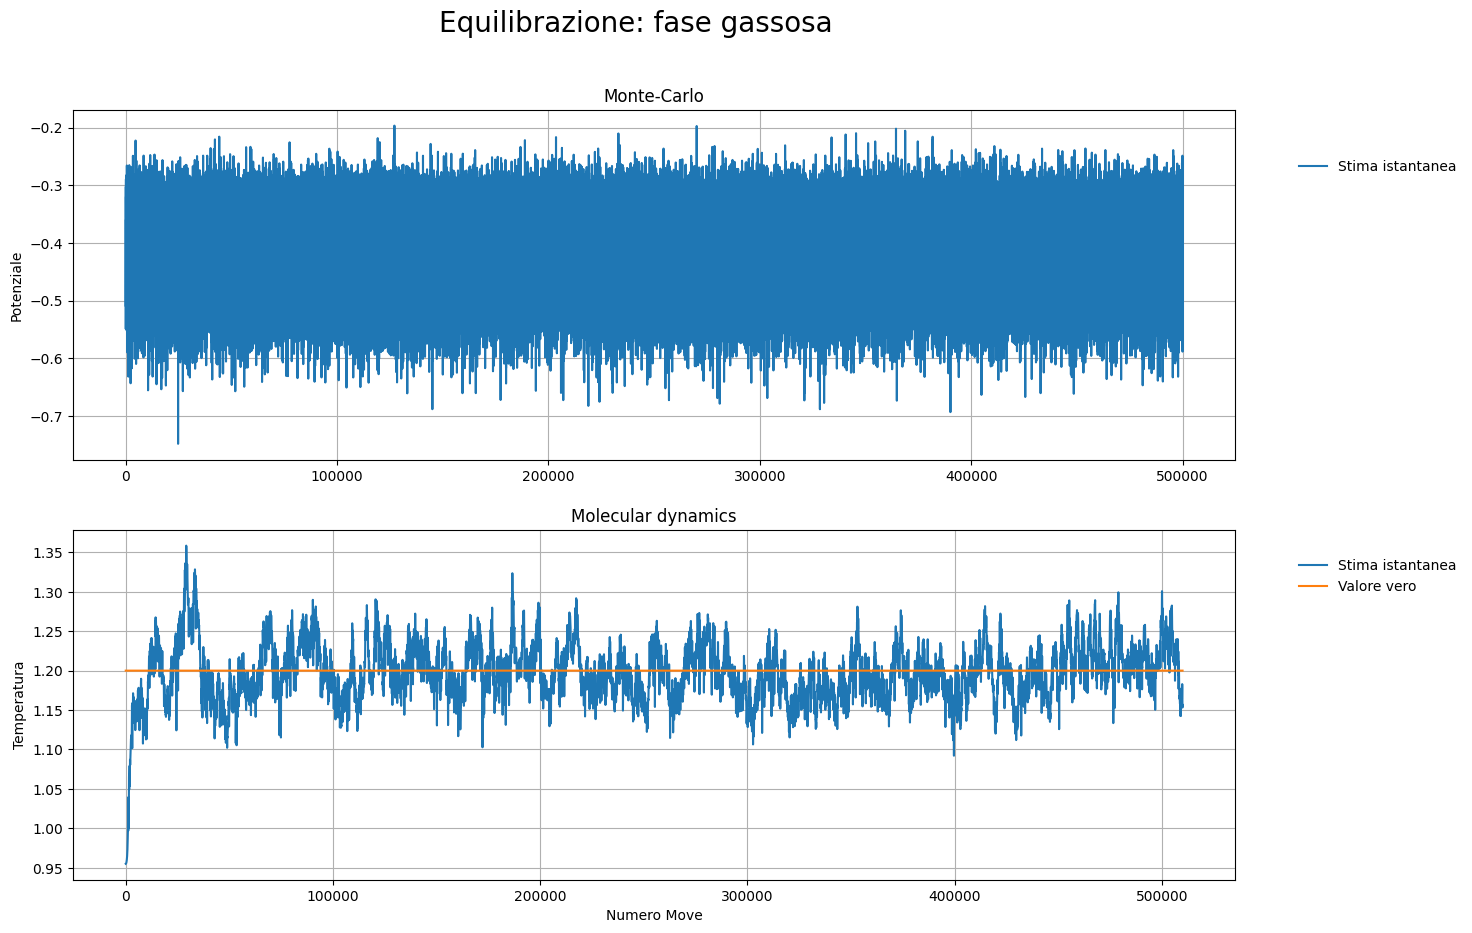

In [3]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
titoli = ['Monte-Carlo', 'Molecular dynamics']


for i in range(0, 2):

    if i == 0:
        axes[i].plot(gassoso[0, 0 : 500000], gassoso[1 , 0 : 500000], label = 'Stima istantanea')
        axes[i].set_ylabel('Potenziale')

    else:
        axes[i].plot(gassoso[0, 500000 : 1010000], gassoso[1 , 500000 : 1010000], label = 'Stima istantanea')
        axes[i].plot(gassoso[0, 500000 : 1010000], np.array([T[0] for i in range(0, 510000)]), label = 'Valore vero')
        axes[i].set_ylabel('Temperatura')

    axes[i].legend(loc=(1.05, 0.8), frameon=False)    
    axes[i].set_title(titoli[i])
    axes[i].grid(True)

axes[1].set_xlabel('Numero Move')    
fig.suptitle(f'Equilibrazione: fase gassosa', fontsize = '20')

plt.show()

#### Fase liquida

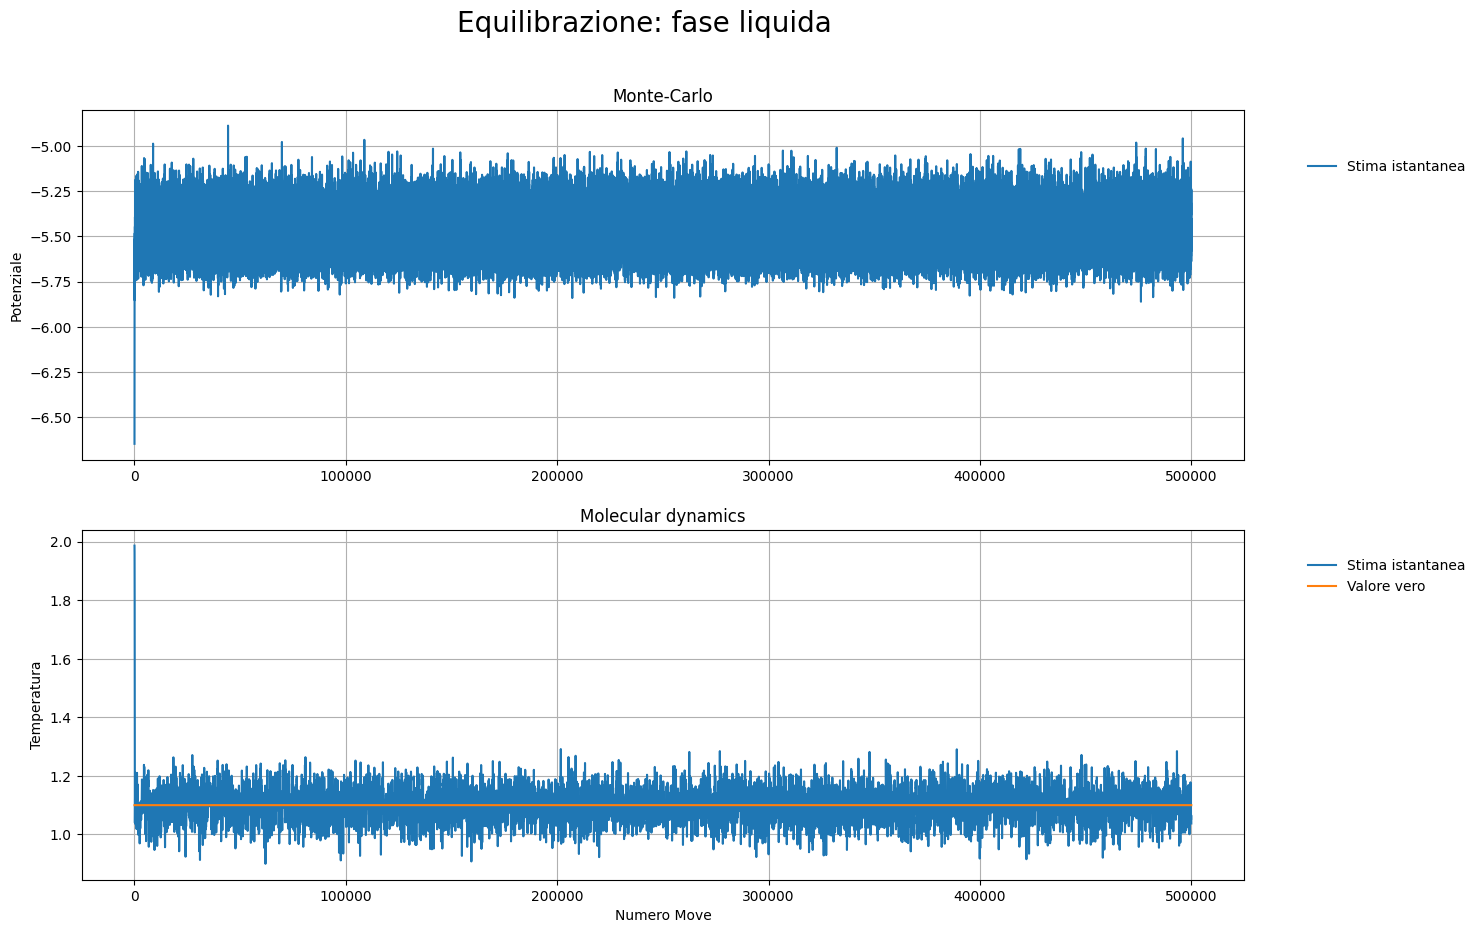

In [4]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
titoli = ['Monte-Carlo', 'Molecular dynamics']


for i in range(0, 2):

    if i == 0:
        axes[i].plot(liquido[0, 0 : 500000], liquido[1 , 0 : 500000], label = 'Stima istantanea')
        axes[i].set_ylabel('Potenziale')

    else:
        axes[i].plot(liquido[0, 500000 : 1000000], liquido[1 , 500000 : 1000000], label = 'Stima istantanea')
        axes[i].plot(liquido[0, 500000 : 1000000], np.array([T[1] for i in range(0, 500000)]), label = 'Valore vero')
        axes[i].set_ylabel('Temperatura')

    axes[i].legend(loc=(1.05, 0.8), frameon=False)    
    axes[i].set_title(titoli[i])
    axes[i].grid(True)

axes[1].set_xlabel('Numero Move')    
fig.suptitle(f'Equilibrazione: fase liquida', fontsize = '20')

plt.show()

#### Fase solida 

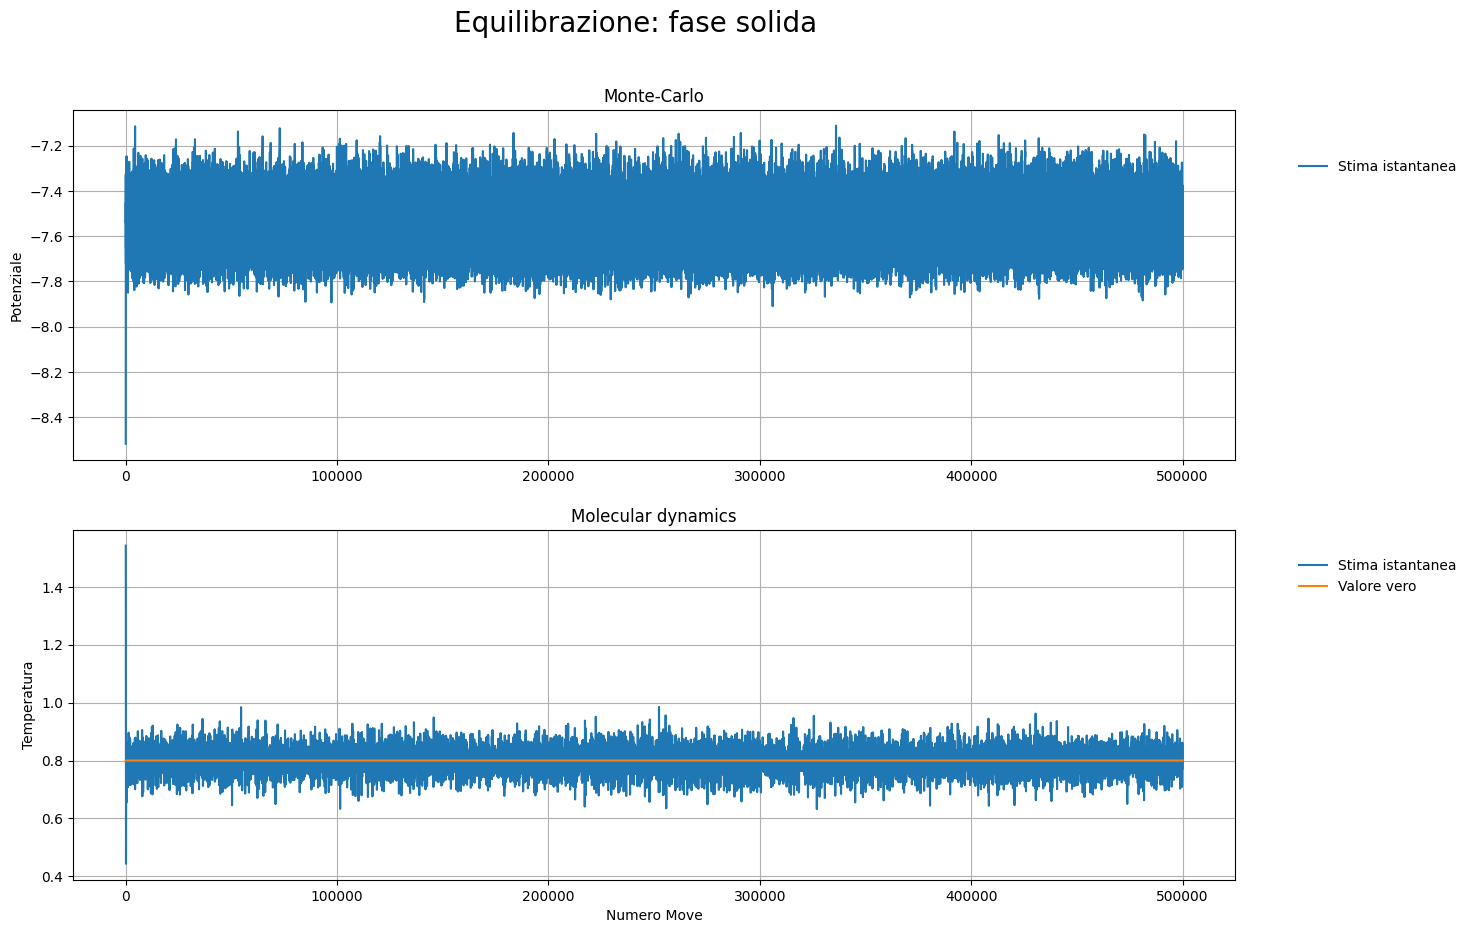

In [5]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
titoli = ['Monte-Carlo', 'Molecular dynamics']

for i in range(0, 2):

    if i == 0:
        axes[i].plot(solido[0, 0 : 500000], solido[1 , 0 : 500000], label = 'Stima istantanea')
        axes[i].set_ylabel('Potenziale')

    else:
        axes[i].plot(solido[0, 500000 : 1000000], solido[1 , 500000 : 1000000], label = 'Stima istantanea')
        axes[i].plot(solido[0, 500000 : 1000000], np.array([T[2] for i in range(0, 500000)]), label = 'Valore vero')
        axes[i].set_ylabel('Temperatura')

    axes[i].legend(loc=(1.05, 0.8), frameon=False)    
    axes[i].set_title(titoli[i])
    axes[i].grid(True)

axes[1].set_xlabel('Numero Move')    
fig.suptitle(f'Equilibrazione: fase solida', fontsize = '20')

plt.show()

Per avere un acceptance rate del 50% lavoriamo con delle delta pari a:
$$
\begin{cases}
    \delta _{sol}\,=\,0.12 \\
    \delta _{liq}\,=\,0.20 \\
    \delta _{gas}\,=\,7
\end{cases}
$$
Nel caso del gas l'acceptance rate si assesta su valori di circa il 60%, ma non si riesce ad ottenere un valore più basso. Le temperature a cui inizializzo il sistema per le simulazioni NVE sono invece le seguenti:
$$
\begin{cases}
    T_{sol}\,=\,1.542 \\
    T_{liq}\,=\,1.9864 \\
    T_{gas}\,=\,0.955
\end{cases}
$$
I tempi di termalizzazione sono gli stessi dell'esercitazione 4. Per quanto riguarda MC, utilizzo come tempo di termalizzazione 10000 per ognuna delle 3 fasi. Per verificare che mi trovo alla temperatura corretta effettuo la media una volta equilibrato il sistema come fatto nell'esercitazione 4.

In [6]:
titolo = np.array(['fase gassosa ', 'fase liquida ', 'fase solida '])

for j in range(0, 3):

    if j==0:
        val = gassoso[1, 510000 : 1010000]
    
    elif j==1:
        val = liquido[1, 500200 : 1000000]
    
    elif j==2:
        val = solido[1, 500300 : 1000000]

    #Contenitori per media e media2
    media = 0
    media2 = 0

    for i in range(0, len(val)):
        media = media * i/(i+1) + val[i]/(i+1)
        media2 = media2 * i/(i+1) + val[i] * val[i]/(i+1)

    print("La temperatura media calcolata con il sistema in equilibrio in " + titolo[j] + str(round(media, 3)))
    print("L'errore associato a questa stima è: " + str(round(math.sqrt((media2 - media*media)/(len(val)-1)), 4)) + '\n')

La temperatura media calcolata con il sistema in equilibrio in fase gassosa 1.201
L'errore associato a questa stima è: 0.0

La temperatura media calcolata con il sistema in equilibrio in fase liquida 1.101
L'errore associato a questa stima è: 0.0001

La temperatura media calcolata con il sistema in equilibrio in fase solida 0.8
L'errore associato a questa stima è: 0.0001



## <span style="color:blue"> Funzioni di auto-correlazione </span>

L'algoritmo di Metropolis presenta due problematiche fondamentali:
1. Il sampling è corretto solo asintoticamente

2. Si ha una forte correlazione fra configurazioni adiacenti

Per ottenere dei buoni valori di aspettazione e degli errori ad essi associati che abbiano un senso abbiamo bisogno di sapere quanto lunghe devono essere le simulazioni ed i singoli blocchi. Vogliamo in particolare una misura del tempo di correlazione $t_c$, che è una misura di quanto il sistema ci impiega a passare da una certa configurazione ad un'altra nettamente differente dalla prima: solitamente il tempo di correlazione è nettamente minore rispetto al tempo di equilibrazione. Un metodo che consente di stimare $t_c$ è il calcolo delle funzioni di auto-correlazione. Due dati prodotti ad n step di distanza presentano un'auto-correlazione pari a:

$$
AC_{\left[x\right]}\,=\,\frac{\frac{1}{n_{max}\,-\,n}\sum_{i=0}^{n_{max}-n}x\left(i\right)x\left(i\,+\,n\right)\,-\,\frac{1}{n_{max}\,-\,n}\sum_{i=0}^{n_{max}-n}x\left(i\right)\,\cdot\,\frac{1}{n_{max}\,-\,n}\sum_{i=0}^{n_{max}-n}x\left(i\,+\,n\right)}{\frac{1}{n_{max}}\sum_{i=0}^{n_{max}}x^2\left(i\right)\,-\,\left(\frac{1}{n_{max}}\sum_{i=0}^{n_{max}}x\left(i\right)\right)^2}
$$

L'auto correlazione ha un decadimento esponenziale con un tempo caratteristico che è proprio $t_c$, ossia:
$$
AC_{[x]}(t)\simeq \exp{\left(-t/t_c\right)}
$$
Il codice utilizzato per produrre le seguenti immagini è riportato in "LSN_Exercises_07.ipynb".

#### Fase gassosa

<center>

![Alt text](Immagini/Auto_gas.png)

</center>

#### Fase liquida

<center>

![Alt text](Immagini/Auto_liq.png)

</center>

#### Fase solida

<center>

![Alt text](Immagini/Auto_sol.png)

</center>

Due valori possono essere considerati come completamente scorrelati se si ha che $t \gt 2t_c$. Per comprendere quale sia il limite inferiore alle dimensioni dei blocchi per ottenere degli errori statisticamente non influenzati dalle varie correlazioni grafichiamo l'andamento dell'incertezza statistica in funzione della dimensione del blocco: si osserva che l'errore inizialmente cresce per poi saturare ad un certo valore. La size per cui ho la saturazione è quella minima che mi garantisce di ottenere una buona stima dell'errore.

#### Fase gassosa

<center>

![Alt text](Immagini/Err_gas.png)

</center>

#### Fase solida

<center>

![Alt text](Immagini/Err_liq.png)

</center>

#### Fase solida

<center>

![Alt text](Immagini/Err_sol.png)

</center>

Notiamo che dei blocchi di lunghezza $1000$ MC move vanno bene per ognuna delle 3 fasi. Le simulazioni saranno però effettuate considerando 50 blocchi da 10000 move ciascuna: sovra-stimare la lunghezza dei blocchi non comporta alcuna problematica a livello di correlazione oppure d'incertezza sui valori di aspettazione.

## <span style="color:blue"> Funzione di distribuzione radiale </span>

La funzione di distribuzione radiale fornisce la probabilità che un paio di atomi si trovino ad una distanza $r$ fra loro relativamente a quella aspettata per una distribuzione completamente casuale(a pari densità). La $g(r)$ viene costruita per $r \in \left[ 0; L/2\right]$ ed il calcolo che ne consente di determinare la forma è implementato dove viene calcolato il viriale: quando trovo un paio di particelle con distanza compresa fra $r$ ed $r\,+\,dr$ incremento il valore del bin corrispondente di 2 (questo per come è costruito il calcolo di w, ossia senza ciclare completamente due volte su tutte le particelle). La normalizzazione del bin è data da:

$$
\rho N\Delta V\left(r\right)\,=\,\frac{4\pi}{3}\rho N\left[\left(r\,+\,dr\right)^3\,-\,r^3\right]
$$

Il focus di questa sezione dell'esercitazione è il confronto fra le $g(r)$ ottenute rispettivamente con MC-NVT e MD-NVE. I due ensamble considerati non sono lo stesso e più la simulazione è lunga, più questa differenza è evidente. Un buon accordo fra le due funzioni di distribuzione radiale consentirebbe comunque di "provare numericamente" la validità della meccanica statistica: l'evoluzione garantita dalle equazioni di Hamilton (meccanica classica) fornisce gli stessi risultati dati dal campionamento della distribuzione di Boltzmann (meccanica statistica).

#### Fase gassosa

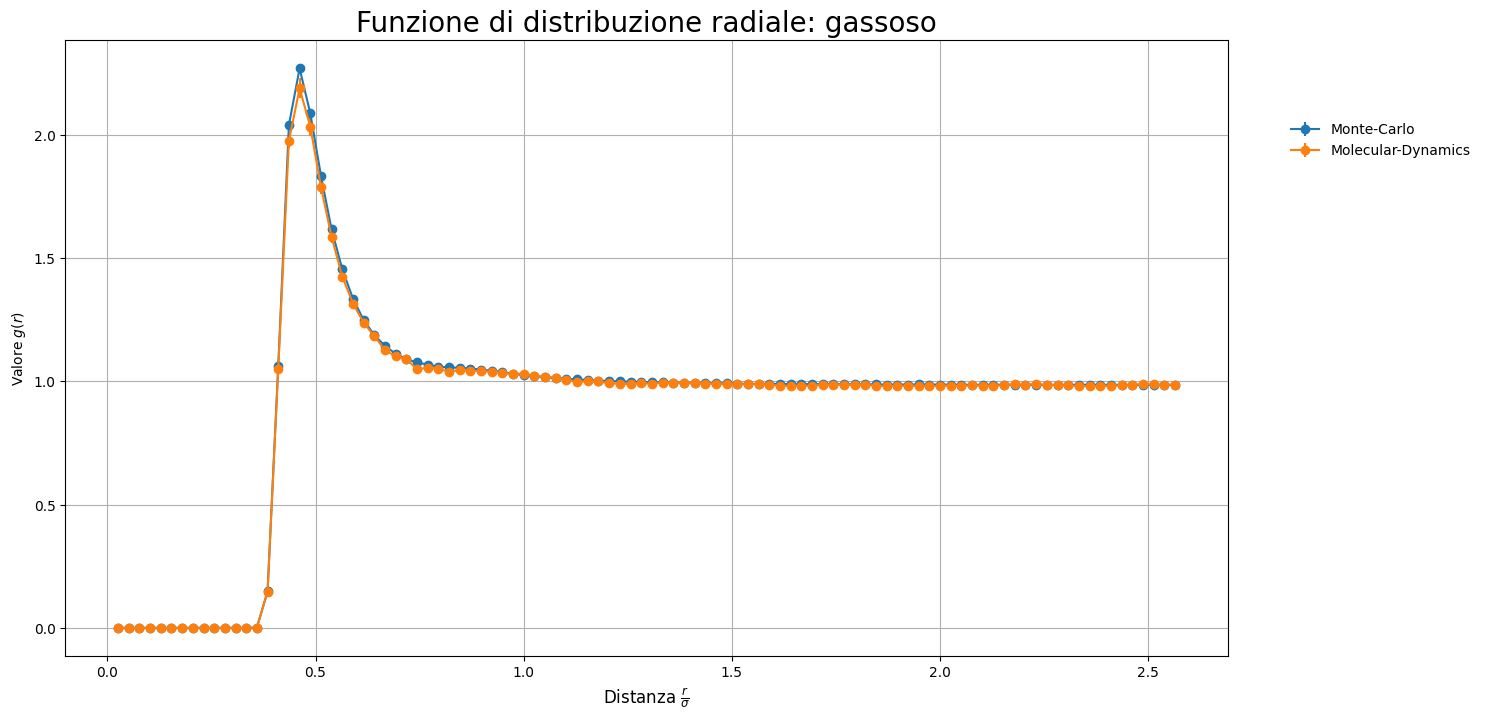

In [7]:
g_r = np.loadtxt("Osservabili/Gassoso/g_r.dat", unpack=True)

figura, plot = plt.subplots(1, 1, figsize=(15, 8))
nomi = ["Monte-Carlo", "Molecular-Dynamics"]

#Dimensione del singolo bin (per asse x)
nbins = 100; rho = 0.8; npart = 108

vol = np.float64(npart)/rho
box = math.pow(vol,1.0/3.0); 
bin_size = box/(2 * nbins)


for i in range(0,2):
    plt.errorbar(g_r[0, 100*i:100*(1+i) ] * bin_size, g_r[1, 100*i:100*(i+1) ], yerr = g_r[2, 100*i:100*(i+1) ], label = nomi[i], fmt = 'o-')

plt.grid(True)
plt.ylabel(r'Valore $g\left(r\right)$')
plt.legend(loc=(1.05, 0.8), frameon=False)
plt.xlabel(r'Distanza $\frac{r}{\sigma}$', fontsize = 12)

plt.title(f"Funzione di distribuzione radiale: gassoso", fontsize = 20)

plt.show()

Per la fase gassosa notiamo che si ha una leggera differenza in corrispondenza del singolo picco. Date le condizioni particolari del gas che stiamo simulando, mi sono chiesto che cosa potesse succedere aumentando la temperatura della simulazione. Si osserva una riduzione di altezza del picco, fino a quasi non comparire per $T\,=\,8$. Il "core" con $g(r)$ identicamente nulla non viene invece modificato perchè il potenziale con il quale viene effettuata la simulazione è sempre quello di Lennard - Jones che presenta una regione fortemente repulsiva per piccoli $r$.

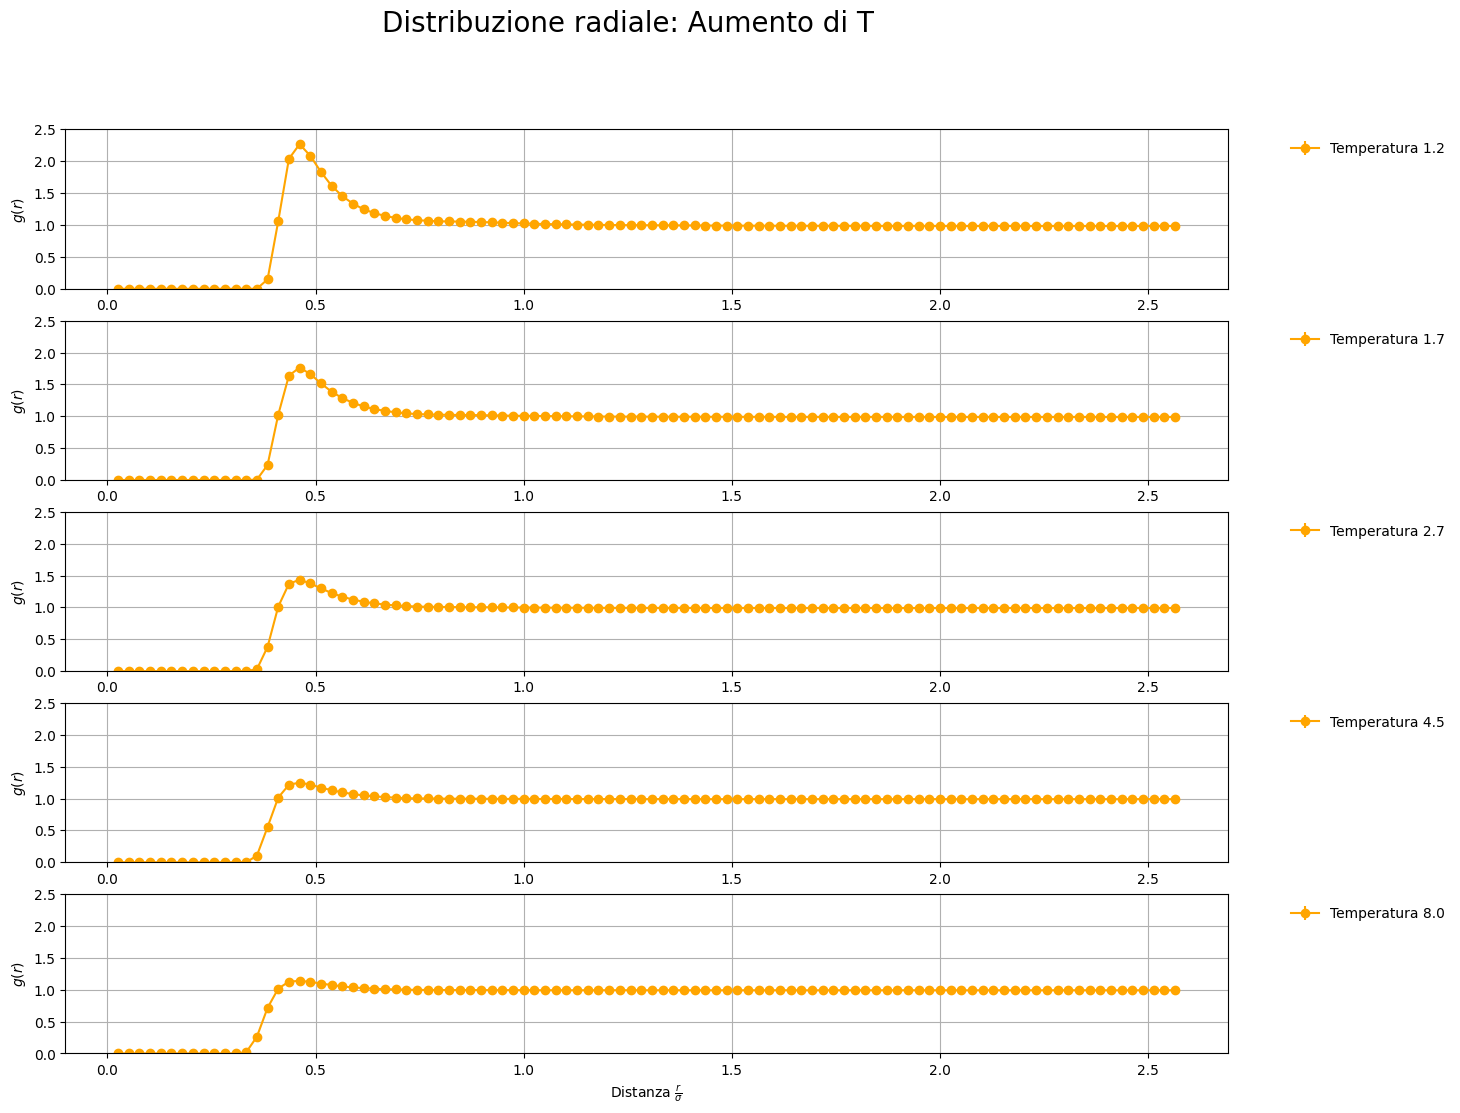

In [8]:
g_r = np.loadtxt("Osservabili/Gassoso/goccioline.dat", unpack=True)

figura, plot = plt.subplots(5, 1, figsize=(15, 12))
titolo = np.array(['Temperatura 1.2', 'Temperatura 1.7', 'Temperatura 2.7', 'Temperatura 4.5', 'Temperatura 8.0'])

for i in range(0, 5):
    plot[i].errorbar(g_r[0, 100*i:100*(1+i)] * bin_size , g_r[1, 100*i:100*(1+i)], yerr = g_r[2, 100*i:100*(1+i)], label = titolo[i], fmt = 'o-', color = 'orange')
    plot[i].grid(True)
    plot[i].set_ylim(0, 2.5)
    plot[i].set_ylabel(r'$g\left(r\right)$')
    plot[i].legend(loc=(1.05, 0.8), frameon=False)


plot[4].set_xlabel(r'Distanza $\frac{r}{\sigma}$')
figura.suptitle('Distribuzione radiale: Aumento di T', fontsize = '20')
plt.show()

#### Fase liquida

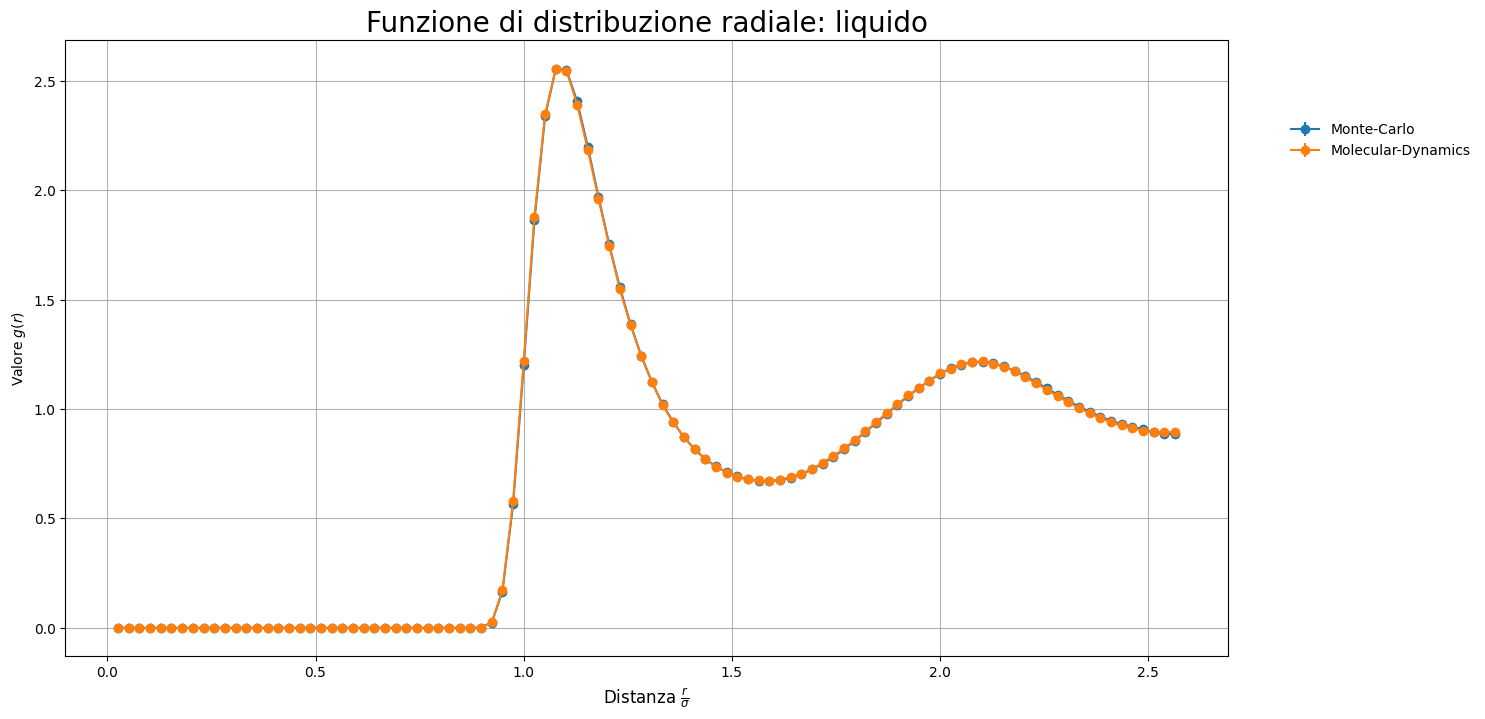

In [9]:
g_r = np.loadtxt("Osservabili/Liquido/g_r.dat", unpack=True)

figura, plot = plt.subplots(1, 1, figsize=(15, 8))
nomi = ["Monte-Carlo", "Molecular-Dynamics"]

#Dimensione del singolo bin (per asse x)
nbins = 100; rho = 0.8; npart = 108

vol = np.float64(npart)/rho
box = math.pow(vol,1.0/3.0); 
bin_size = box/(2 * nbins)


for i in range(0,2):
    plt.errorbar(g_r[0, 100*i:100*(1+i) ] * bin_size, g_r[1, 100*i:100*(i+1) ], yerr = g_r[2, 100*i:100*(i+1) ], label = nomi[i], fmt = 'o-')

plt.legend(loc=(1.05, 0.8), frameon=False)
plt.ylabel(r'Valore $g\left(r\right)$')
plt.grid(True)

plt.xlabel(r'Distanza $\frac{r}{\sigma}$', fontsize = 12)
plt.title(f"Funzione di distribuzione radiale: liquido", fontsize = 20)

plt.grid(True)
plt.show()

#### Fase solida

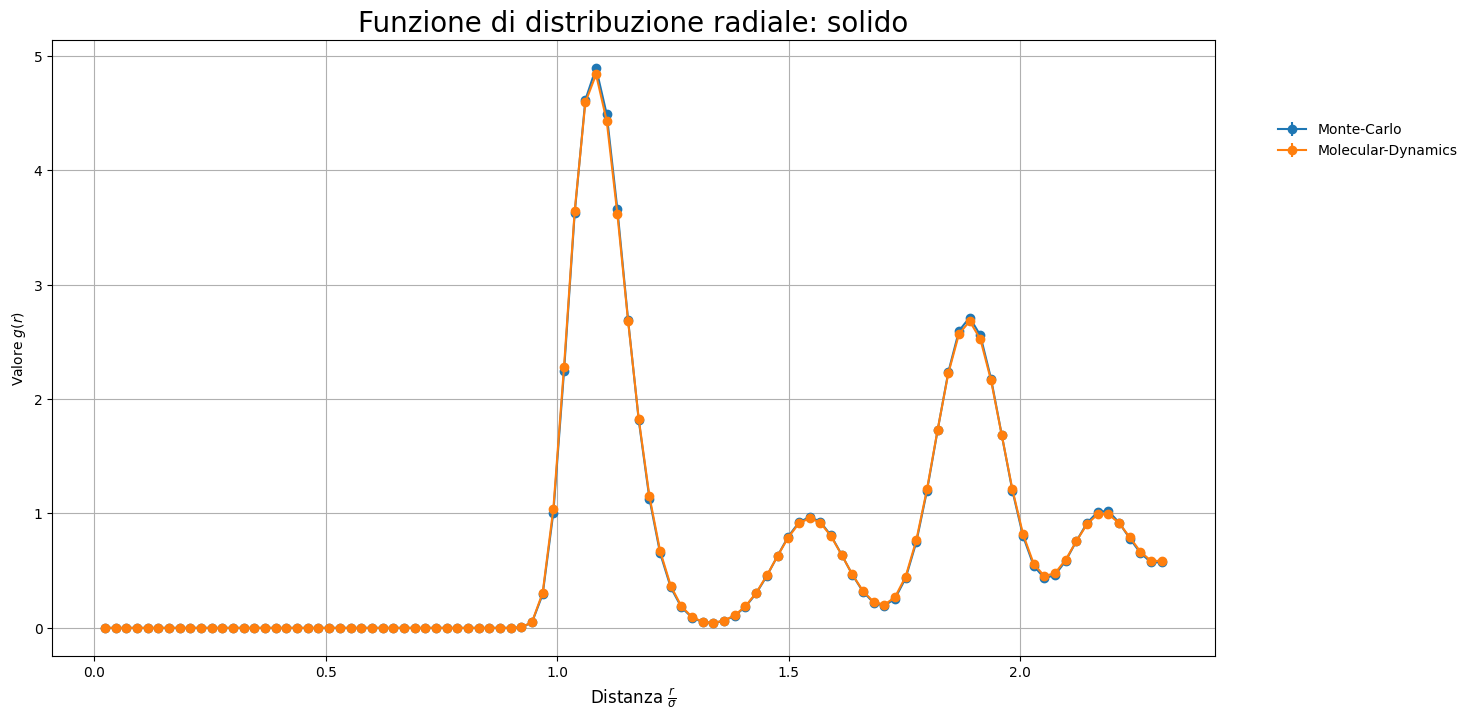

In [10]:
g_r = np.loadtxt("Osservabili/Solido/g_r.dat", unpack=True)

figura, plot = plt.subplots(1, 1, figsize=(15, 8))
nomi = ["Monte-Carlo", "Molecular-Dynamics"]

#Dimensione del singolo bin (per asse x)
nbins = 100; rho = 1.1; npart = 108

vol = np.float64(npart)/rho
box = math.pow(vol,1.0/3.0); 
bin_size = box/(2 * nbins)


for i in range(0,2):
    plt.errorbar(g_r[0, 100*i:100*(1+i) ] * bin_size, g_r[1, 100*i:100*(i+1) ], yerr = g_r[2, 100*i:100*(i+1) ], label = nomi[i], fmt = 'o-')

plt.legend(loc=(1.05, 0.8), frameon=False)
plt.ylabel(r'Valore $g\left(r\right)$')
plt.grid(True)

plt.xlabel(r'Distanza $\frac{r}{\sigma}$', fontsize = 12)
plt.title(f"Funzione di distribuzione radiale: solido", fontsize = 20)

plt.grid(True)
plt.show()

## <span style="color:blue"> Pressione </span>

Pressione fase gassosa: 0.049
Errore associato: 2e-05

Pressione fase liquida: 1.40006
Errore associato: 0.00412

Pressione fase solida: 7.59356
Errore associato: 0.00329



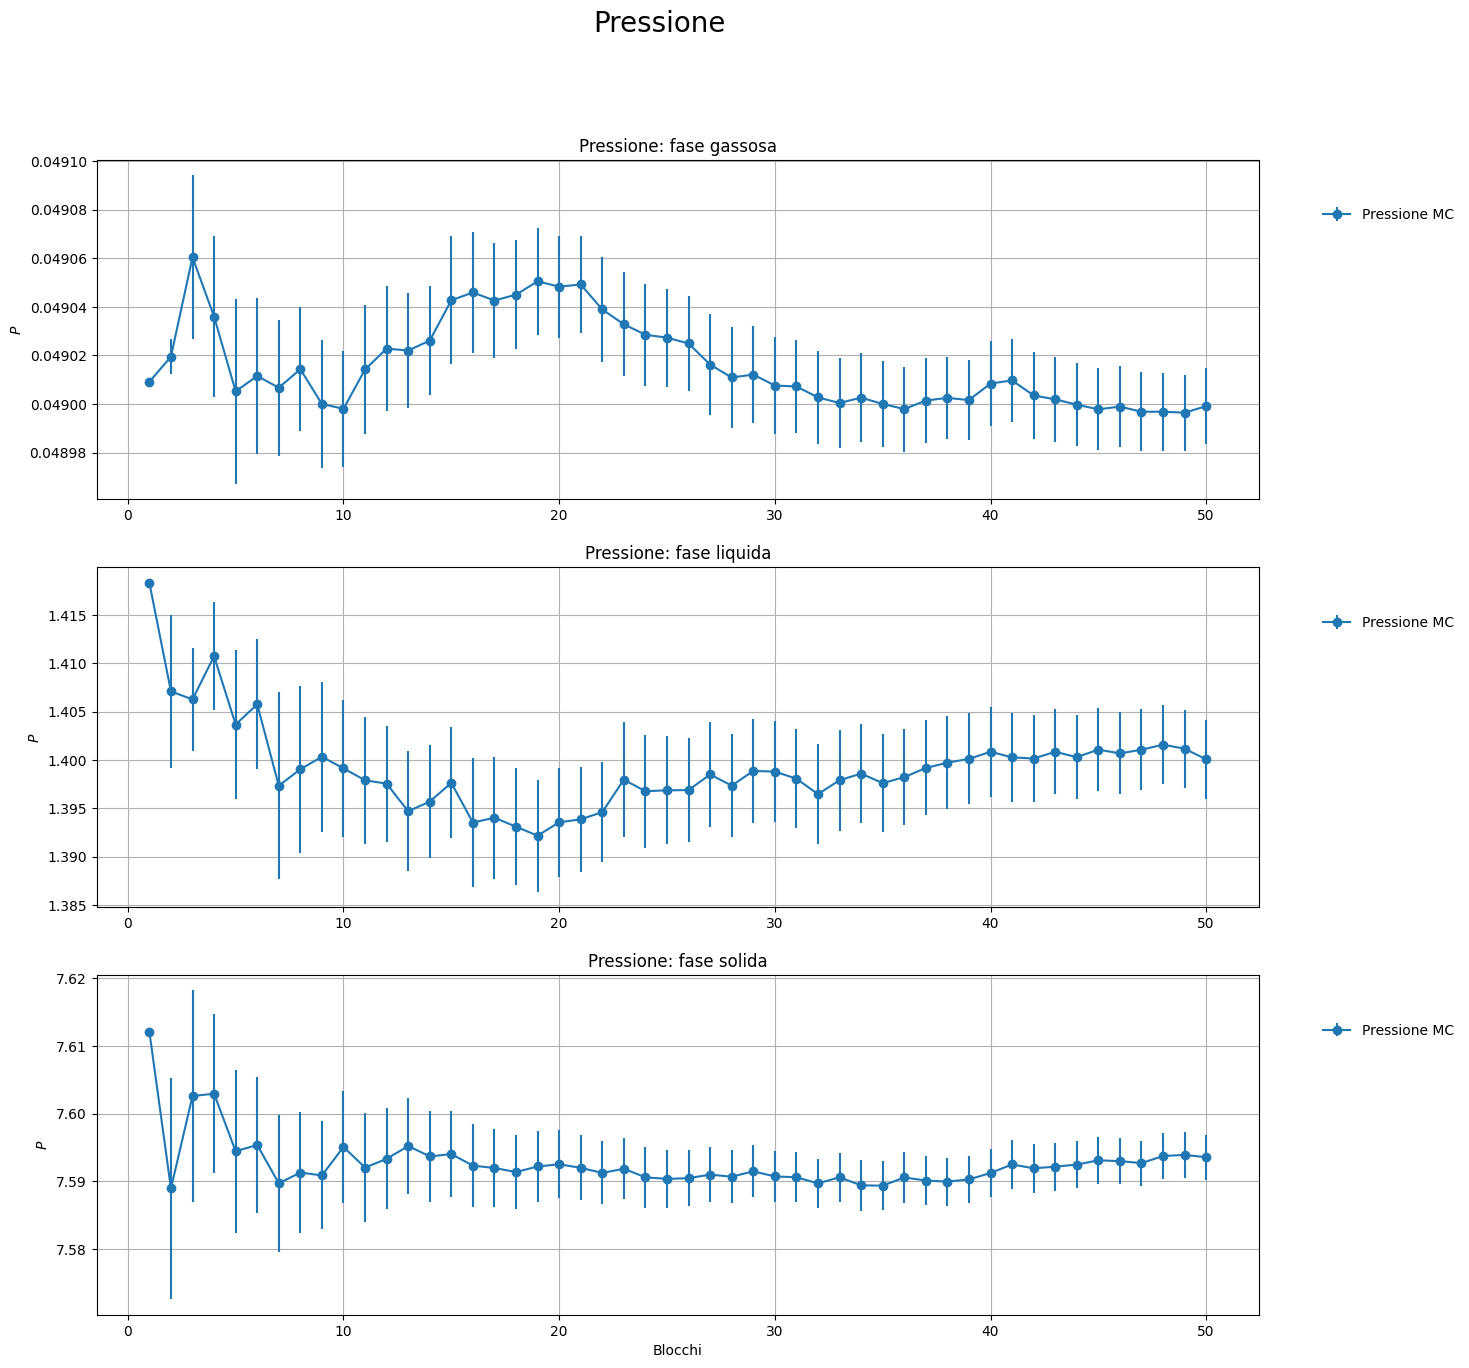

In [11]:
pressione = np.loadtxt("Osservabili/Pressione.dat", unpack = True)
titolo = np.array(['fase gassosa', 'fase liquida', 'fase solida'])

fig, ax = plt.subplots(3, 1, figsize = (15,15))

for i in range(0, 3):
    ax[i].errorbar(pressione[0, 0 : 50], pressione[2, 50*i:50*(i+1)], yerr = pressione[3, 50*i:50*(i+1)], label = 'Pressione MC', fmt = 'o-')
    
    ax[i].legend(loc=(1.05, 0.8), frameon=False)
    ax[i].set_title('Pressione: ' + titolo[i])
    ax[i].set_ylabel(r'$P$')
    ax[i].grid(True)

    print("Pressione " + titolo[i] + ": " + str(round(pressione[2, 50*(i+1)-1], 5)))
    print("Errore associato: " + str(round(pressione[3, 50*(i+1)-1], 5)) + '\n')

ax[2].set_xlabel('Blocchi')
fig.suptitle('Pressione', size = 20)
plt.show()

## <span style="color:blue"> Energia potenziale </span>

Potenziale fase gassosa: -0.41431
Errore associato: 0.00016

Potenziale fase liquida: -5.46361
Errore associato: 0.00074

Potenziale fase solida: -7.54659
Errore associato: 0.00061



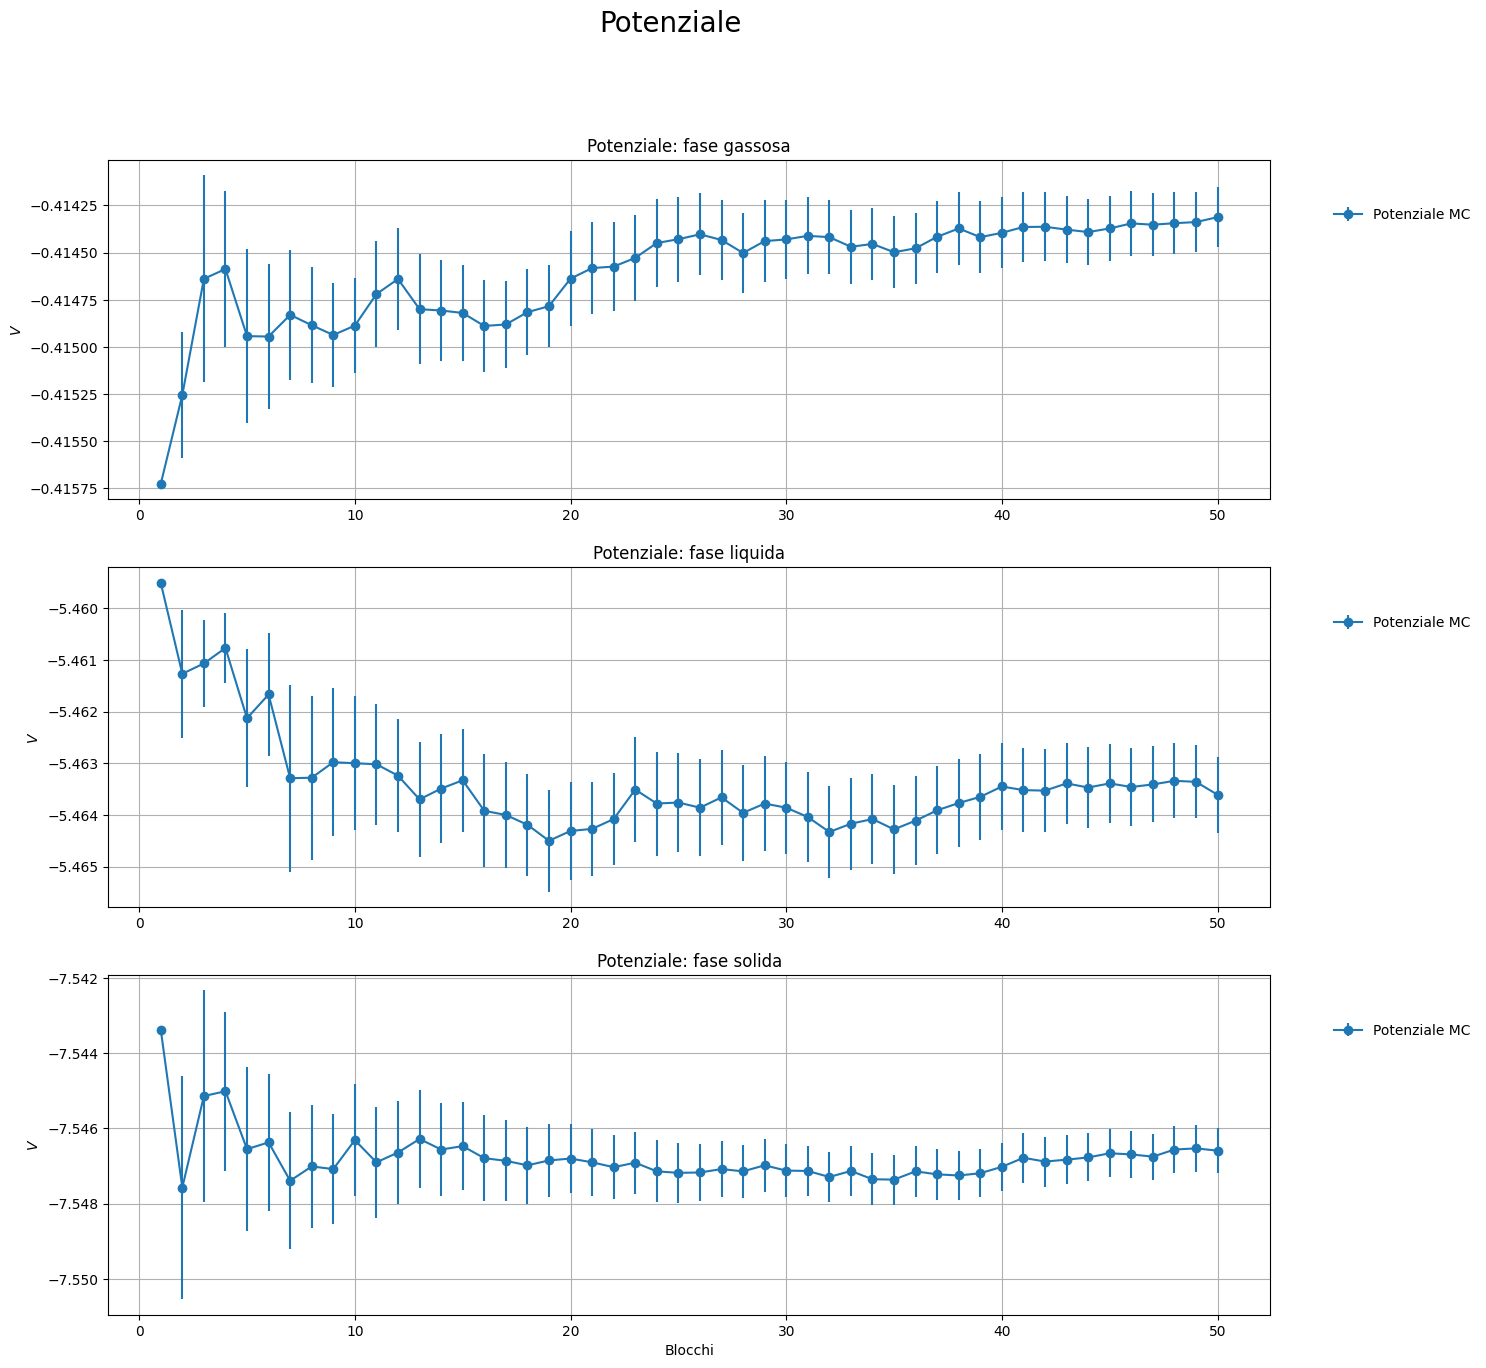

In [12]:
potenziale = np.loadtxt("Osservabili/Potenziale.dat", unpack = True)
titolo = np.array(['fase gassosa', 'fase liquida', 'fase solida'])

fig, ax = plt.subplots(3, 1, figsize = (15,15))

for i in range(0, 3):
    ax[i].errorbar(potenziale[0, 0 : 50], potenziale[2, 50*i:50*(i+1)], yerr = potenziale[3, 50*i:50*(i+1)], label = 'Potenziale MC', fmt = 'o-')
    
    ax[i].legend(loc=(1.05, 0.8), frameon=False)
    ax[i].set_title('Potenziale: ' + titolo[i])
    ax[i].set_ylabel(r'$V$')
    ax[i].grid(True)

    print("Potenziale " + titolo[i] + ": " + str(round(potenziale[2, 50*(i+1)-1], 5)))
    print("Errore associato: " + str(round(potenziale[3, 50*(i+1)-1], 5)) + '\n')

ax[2].set_xlabel('Blocchi')
fig.suptitle('Potenziale', size = 20)
plt.show()